# Operations de Base sur les Videos

**Module :** 01-Video-Foundation  
**Niveau :** Debutant  
**Technologies :** moviepy, ffmpeg-python, decord, imageio  
**Duree estimee :** 35 minutes  
**VRAM :** 0 (CPU uniquement)  

## Objectifs d'Apprentissage

- [ ] Creer une video de test a partir d'images generees programmatiquement
- [ ] Manipuler des videos avec moviepy (trimming, concatenation, overlay texte)
- [ ] Analyser les metadonnees video avec ffmpeg-python (fps, codec, resolution)
- [ ] Extraire des frames rapidement avec decord (VideoReader)
- [ ] Lire et ecrire des frames video avec imageio
- [ ] Afficher une grille de frames avec matplotlib

## Prerequis

- Python 3.10+
- FFmpeg installe sur le systeme (`winget install FFmpeg` ou `apt install ffmpeg`)
- Packages : `moviepy`, `ffmpeg-python`, `decord`, `imageio`, `imageio-ffmpeg`, `Pillow`, `matplotlib`

In [1]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration notebook
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"

# Parametres video de test
sample_fps = 24                    # FPS de la video de test
sample_duration = 5                # Duree en secondes
output_format = "mp4"              # Format de sortie
sample_width = 640                 # Largeur video de test
sample_height = 480                # Hauteur video de test

# Configuration operations
enable_moviepy_demo = True         # Demonstration moviepy
enable_ffmpeg_probe = True         # Analyse ffmpeg-python
enable_decord_demo = True          # Extraction decord
enable_imageio_demo = True         # Lecture/ecriture imageio
save_results = True                # Sauvegarder resultats

In [2]:
# Parameters
notebook_mode = "batch"


In [3]:
# Setup environnement et imports
import os
import sys
import json
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import logging

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Ajouter FFmpeg au PATH (installation locale)
FFMPEG_PATHS = [
    "D:/Dev/CoursIA/tools/ffmpeg/bin",
    "C:/Program Files/ffmpeg/bin",
    "C:/tools/ffmpeg/bin",
]
for ffmpeg_path in FFMPEG_PATHS:
    if Path(ffmpeg_path).exists():
        os.environ["PATH"] = f"{ffmpeg_path};{os.environ.get('PATH', '')}"
        print(f"FFmpeg ajouté au PATH depuis: {ffmpeg_path}")
        break

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.video_helpers import get_video_info, extract_frames, display_frame_grid
        print("Helpers video importes")
    except ImportError as e:
        print(f"Helpers video non disponibles ({e}) - mode autonome")

# Repertoire de sortie
OUTPUT_DIR = GENAI_ROOT / 'outputs' / 'video_basics'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('video_basics')

print(f"Operations de Base sur les Videos")
print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}, FPS : {sample_fps}, Duree : {sample_duration}s")
print(f"Sortie : {OUTPUT_DIR}")

Helpers video importes
Operations de Base sur les Videos
Date : 2026-02-26 07:49:16
Mode : batch, FPS : 24, Duree : 5s
Sortie : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\video_basics


In [4]:
# Chargement .env et verification des dependances
from dotenv import load_dotenv

current_path = Path.cwd()
found_env = False
for _ in range(4):
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis : {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve (non requis pour ce notebook CPU)")

# Verification des dependances video
print("\n--- VERIFICATION DES DEPENDANCES ---")
print("=" * 40)

dependencies = {}

# moviepy 2.x a une structure differente de 1.x
try:
    import moviepy
    from moviepy import VideoFileClip, concatenate_videoclips, CompositeVideoClip
    dependencies['moviepy'] = True
    print(f"moviepy : disponible (v{moviepy.__version__})")
except ImportError as e:
    dependencies['moviepy'] = False
    print(f"moviepy : NON INSTALLE (pip install moviepy)")

try:
    import ffmpeg
    dependencies['ffmpeg-python'] = True
    print(f"ffmpeg-python : disponible")
except ImportError:
    dependencies['ffmpeg-python'] = False
    print(f"ffmpeg-python : NON INSTALLE (pip install ffmpeg-python)")

try:
    import decord
    decord.bridge.set_bridge('native')
    dependencies['decord'] = True
    print(f"decord : disponible")
except ImportError:
    dependencies['decord'] = False
    print(f"decord : NON INSTALLE (pip install decord)")

try:
    import imageio
    dependencies['imageio'] = True
    print(f"imageio : disponible (v{imageio.__version__})")
except ImportError:
    dependencies['imageio'] = False
    print(f"imageio : NON INSTALLE (pip install imageio imageio-ffmpeg)")

available_count = sum(dependencies.values())
total_count = len(dependencies)
print(f"\nDependances disponibles : {available_count}/{total_count}")
if available_count < total_count:
    missing = [k for k, v in dependencies.items() if not v]
    print(f"Manquantes : {', '.join(missing)}")
    print("Les sections correspondantes seront sautees.")

Fichier .env charge depuis : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env

--- VERIFICATION DES DEPENDANCES ---


moviepy : disponible (v2.1.2)
ffmpeg-python : disponible


decord : disponible
imageio : disponible (v2.37.2)

Dependances disponibles : 4/4


## Section 1 : Creation d'une video de test

Avant de manipuler des videos, nous devons en creer une. Nous allons generer des frames colorees
avec du texte superpose a l'aide de PIL, puis les assembler en video avec imageio.
Cela rend le notebook entierement autonome, sans besoin de fichiers externes.


--- CREATION VIDEO DE TEST ---
Generation de 120 frames (640x480)...


Frames generees en 0.29s
  Nombre : 120
  Shape : (480, 640, 3)
  Dtype : uint8
  Memoire : ~105.5 MB

Assemblage video avec imageio...


Video sauvegardee : D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\video_basics\test_video.mp4
  Taille : 64.1 KB
  Duree : 5s


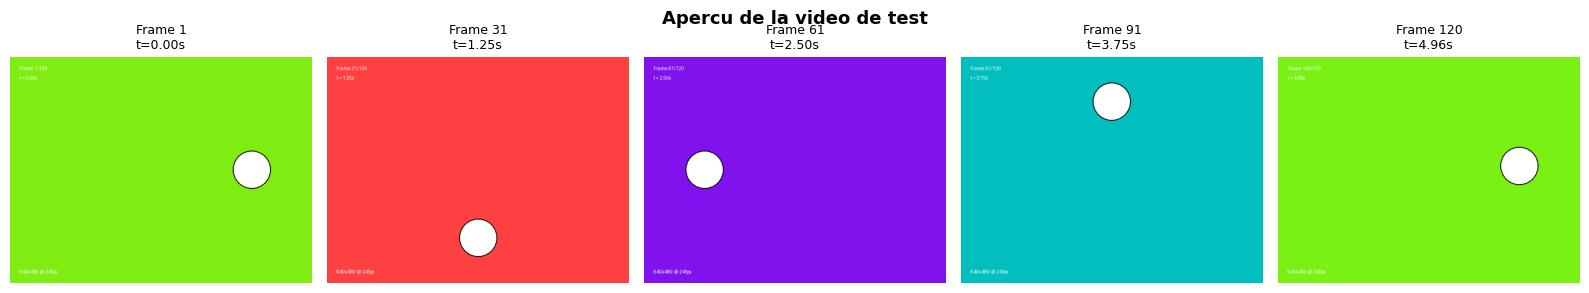

In [5]:
# Creation d'une video de test a partir de frames generees
print("\n--- CREATION VIDEO DE TEST ---")
print("=" * 40)

def generate_test_frames(n_frames: int, width: int, height: int,
                         fps: float) -> List[np.ndarray]:
    """
    Genere une sequence de frames avec gradient de couleur et texte.
    
    Args:
        n_frames: Nombre total de frames
        width: Largeur en pixels
        height: Hauteur en pixels
        fps: Images par seconde (pour affichage timestamp)
    
    Returns:
        Liste de numpy arrays (H, W, 3) uint8
    """
    frames = []
    for i in range(n_frames):
        # Progression temporelle
        t = i / n_frames
        timestamp = i / fps
        
        # Couleur de fond avec gradient anime
        r = int(128 + 127 * np.sin(2 * np.pi * t))
        g = int(128 + 127 * np.sin(2 * np.pi * t + 2 * np.pi / 3))
        b = int(128 + 127 * np.sin(2 * np.pi * t + 4 * np.pi / 3))
        
        # Creer image PIL avec couleur de fond
        img = Image.new('RGB', (width, height), (r, g, b))
        draw = ImageDraw.Draw(img)
        
        # Ajouter un cercle qui se deplace
        cx = int(width * 0.5 + width * 0.3 * np.cos(2 * np.pi * t))
        cy = int(height * 0.5 + height * 0.3 * np.sin(2 * np.pi * t))
        radius = 40
        draw.ellipse([cx - radius, cy - radius, cx + radius, cy + radius],
                     fill='white', outline='black', width=2)
        
        # Ajouter du texte
        text_frame = f"Frame {i + 1}/{n_frames}"
        text_time = f"t = {timestamp:.2f}s"
        text_info = f"{width}x{height} @ {fps}fps"
        
        # Utiliser la police par defaut (pas besoin de fichier .ttf)
        draw.text((20, 20), text_frame, fill='white')
        draw.text((20, 40), text_time, fill='white')
        draw.text((20, height - 30), text_info, fill='white')
        
        frames.append(np.array(img))
    
    return frames


# Generer les frames
n_frames = sample_fps * sample_duration
print(f"Generation de {n_frames} frames ({sample_width}x{sample_height})...")

start_time = time.time()
test_frames = generate_test_frames(n_frames, sample_width, sample_height, sample_fps)
gen_time = time.time() - start_time

print(f"Frames generees en {gen_time:.2f}s")
print(f"  Nombre : {len(test_frames)}")
print(f"  Shape : {test_frames[0].shape}")
print(f"  Dtype : {test_frames[0].dtype}")
print(f"  Memoire : ~{len(test_frames) * test_frames[0].nbytes / 1024 / 1024:.1f} MB")

# Assembler en fichier video avec imageio
test_video_path = OUTPUT_DIR / f"test_video.{output_format}"

if dependencies.get('imageio', False):
    print(f"\nAssemblage video avec imageio...")
    writer = imageio.get_writer(str(test_video_path), fps=sample_fps, codec='libx264')
    for frame in test_frames:
        writer.append_data(frame)
    writer.close()
    
    file_size = test_video_path.stat().st_size / 1024
    print(f"Video sauvegardee : {test_video_path}")
    print(f"  Taille : {file_size:.1f} KB")
    print(f"  Duree : {sample_duration}s")
else:
    print("imageio non disponible - video non creee")

# Apercu : afficher quelques frames
preview_indices = [0, n_frames // 4, n_frames // 2, 3 * n_frames // 4, n_frames - 1]
fig, axes = plt.subplots(1, len(preview_indices), figsize=(16, 3))
for ax, idx in zip(axes, preview_indices):
    ax.imshow(test_frames[idx])
    ax.set_title(f"Frame {idx + 1}\nt={idx/sample_fps:.2f}s", fontsize=9)
    ax.axis('off')
plt.suptitle("Apercu de la video de test", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : Creation de la video de test

| Aspect | Valeur | Signification |
|--------|--------|---------------|
| Frames generees | N = fps x duree | Chaque frame est une image RGB independante |
| Codec | libx264 (H.264) | Standard de compression video le plus repandu |
| Taille fichier | Variable | La compression H.264 reduit enormement la taille par rapport aux frames brutes |
| Memoire RAM | ~N x W x H x 3 bytes | En memoire, chaque frame occupe width * height * 3 octets |

**Points cles** :
1. La generation de frames avec PIL est simple mais lente pour de grandes resolutions
2. imageio fournit une interface Python propre au-dessus de FFmpeg
3. Le rapport de compression entre les frames brutes et le fichier MP4 est generalement superieur a 10:1

## Section 2 : Manipulation avec moviepy

moviepy est la bibliotheque Python de reference pour le montage video programmatique :
trimming, concatenation, overlay de texte, transitions.

In [6]:
# Manipulation video avec moviepy
if enable_moviepy_demo and dependencies.get('moviepy', False) and test_video_path.exists():
    from moviepy import VideoFileClip, concatenate_videoclips, CompositeVideoClip
    
    print("\n--- MANIPULATION AVEC MOVIEPY ---")
    print("=" * 40)
    
    # Charger la video
    clip = VideoFileClip(str(test_video_path))
    print(f"Video chargee : {test_video_path.name}")
    print(f"  Duree : {clip.duration:.2f}s")
    print(f"  FPS : {clip.fps}")
    print(f"  Resolution : {clip.size[0]}x{clip.size[1]}")
    
    # 1. Trimming (decoupe) - moviepy 2.x utilise subclipped()
    print("\n1. Trimming (decoupe)")
    trim_start = 1.0
    trim_end = 3.0
    clip_trimmed = clip.subclipped(trim_start, trim_end)  # moviepy 2.x API
    trimmed_path = OUTPUT_DIR / "trimmed.mp4"
    clip_trimmed.write_videofile(str(trimmed_path), logger=None)
    print(f"  Segment [{trim_start}s - {trim_end}s] extrait")
    print(f"  Duree resultat : {clip_trimmed.duration:.2f}s")
    print(f"  Sauvegarde : {trimmed_path.name}")
    
    # 2. Concatenation
    print("\n2. Concatenation")
    part_a = clip.subclipped(0, 2)  # moviepy 2.x API
    part_b = clip.subclipped(3, 5)  # moviepy 2.x API
    clip_concat = concatenate_videoclips([part_a, part_b])
    concat_path = OUTPUT_DIR / "concatenated.mp4"
    clip_concat.write_videofile(str(concat_path), logger=None)
    print(f"  Parties A (0-2s) + B (3-5s) concatenees")
    print(f"  Duree resultat : {clip_concat.duration:.2f}s")
    
    # 3. Overlay texte (optionnel - necessite ImageMagick)
    print("\n3. Overlay texte")
    try:
        from moviepy import TextClip
        txt_clip = TextClip("CoursIA - Video Foundation",
                           font_size=30, color='white',
                           font='Arial')
        txt_clip = txt_clip.with_position('bottom').with_duration(clip.duration)
        clip_with_text = CompositeVideoClip([clip, txt_clip])
        text_path = OUTPUT_DIR / "with_text_overlay.mp4"
        clip_with_text.write_videofile(str(text_path), logger=None)
        print(f"  Texte superpose sur toute la duree")
        print(f"  Sauvegarde : {text_path.name}")
        txt_clip.close()
        clip_with_text.close()
    except Exception as e:
        print(f"  Overlay texte non disponible ({type(e).__name__}: {str(e)[:80]})")
        print(f"  ImageMagick ou polices non configurees - fonctionnalite optionnelle")
    
    # Liberation memoire
    clip.close()
    clip_trimmed.close()
    clip_concat.close()
    part_a.close()
    part_b.close()
    
    print("\nOperations moviepy terminees")
else:
    if not dependencies.get('moviepy', False):
        print("moviepy non disponible - section sautee")
    elif not test_video_path.exists():
        print("Video de test non trouvee - section sautee")
    else:
        print("Demonstration moviepy desactivee (enable_moviepy_demo=False)")


--- MANIPULATION AVEC MOVIEPY ---
Video chargee : test_video.mp4
  Duree : 5.00s
  FPS : 24.0
  Resolution : 640x480

1. Trimming (decoupe)


  Segment [1.0s - 3.0s] extrait
  Duree resultat : 2.00s
  Sauvegarde : trimmed.mp4

2. Concatenation


  Parties A (0-2s) + B (3-5s) concatenees
  Duree resultat : 4.00s

3. Overlay texte
  Overlay texte non disponible (TypeError: multiple values for argument 'font')
  ImageMagick ou polices non configurees - fonctionnalite optionnelle

Operations moviepy terminees


### Interpretation : Manipulations moviepy

| Operation | Methode | Description |
|-----------|---------|-------------|
| Trimming | `clip.subclip(start, end)` | Extrait un segment temporel |
| Concatenation | `concatenate_videoclips([a, b])` | Joint bout a bout plusieurs clips |
| Overlay texte | `CompositeVideoClip([clip, txt])` | Superpose des elements visuels |
| Ecriture | `clip.write_videofile(path)` | Encode et sauvegarde le resultat |

**Points cles** :
1. moviepy travaille de maniere paresseuse (lazy) : les frames ne sont calculees qu'a l'ecriture
2. Toujours fermer les clips avec `.close()` pour liberer les handles FFmpeg
3. TextClip necessite ImageMagick installe sur le systeme

## Section 3 : Analyse des metadonnees avec ffmpeg-python

ffmpeg-python permet d'interroger les metadonnees d'un fichier video sans le decoder entierement.
C'est beaucoup plus rapide que de charger la video complete.

In [7]:
# Analyse des metadonnees video avec ffmpeg-python
if enable_ffmpeg_probe and dependencies.get('ffmpeg-python', False) and test_video_path.exists():
    import ffmpeg
    
    print("\n--- ANALYSE METADONNEES AVEC FFMPEG-PYTHON ---")
    print("=" * 50)
    
    try:
        # Probe du fichier video
        probe = ffmpeg.probe(str(test_video_path))
        
        # Informations generales
        format_info = probe['format']
        print(f"\nInformations generales :")
        print(f"  Fichier : {Path(format_info['filename']).name}")
        print(f"  Format : {format_info.get('format_long_name', 'N/A')}")
        print(f"  Duree : {float(format_info.get('duration', 0)):.2f}s")
        print(f"  Taille : {int(format_info.get('size', 0)) / 1024:.1f} KB")
        print(f"  Bitrate : {int(format_info.get('bit_rate', 0)) / 1000:.0f} kbps")
        print(f"  Nombre de flux : {format_info.get('nb_streams', 0)}")
        
        # Flux video
        video_streams = [s for s in probe['streams'] if s['codec_type'] == 'video']
        audio_streams = [s for s in probe['streams'] if s['codec_type'] == 'audio']
        
        if video_streams:
            vs = video_streams[0]
            fps_parts = vs.get('r_frame_rate', '0/1').split('/')
            fps = int(fps_parts[0]) / int(fps_parts[1]) if len(fps_parts) == 2 else 0
            
            print(f"\nFlux video :")
            print(f"  Codec : {vs.get('codec_name', 'N/A')} ({vs.get('codec_long_name', '')})")
            print(f"  Resolution : {vs.get('width', 0)}x{vs.get('height', 0)}")
            print(f"  FPS : {fps:.2f}")
            print(f"  Profil : {vs.get('profile', 'N/A')}")
            print(f"  Pixel format : {vs.get('pix_fmt', 'N/A')}")
            print(f"  Frames totales : {vs.get('nb_frames', 'N/A')}")
        
        if audio_streams:
            aus = audio_streams[0]
            print(f"\nFlux audio :")
            print(f"  Codec : {aus.get('codec_name', 'N/A')}")
            print(f"  Sample rate : {aus.get('sample_rate', 'N/A')} Hz")
            print(f"  Canaux : {aus.get('channels', 'N/A')}")
        else:
            print(f"\nFlux audio : aucun (video muette)")
        
        # Tableau recapitulatif
        print(f"\nTableau recapitulatif :")
        print(f"{'Propriete':<25} {'Valeur':<30}")
        print("-" * 55)
        summary = [
            ("Format", format_info.get('format_name', 'N/A')),
            ("Codec video", vs.get('codec_name', 'N/A') if video_streams else 'N/A'),
            ("Resolution", f"{vs.get('width', 0)}x{vs.get('height', 0)}" if video_streams else 'N/A'),
            ("FPS", f"{fps:.2f}" if video_streams else 'N/A'),
            ("Duree", f"{float(format_info.get('duration', 0)):.2f}s"),
            ("Bitrate", f"{int(format_info.get('bit_rate', 0)) / 1000:.0f} kbps"),
            ("Taille", f"{int(format_info.get('size', 0)) / 1024:.1f} KB"),
            ("Audio", "oui" if audio_streams else "non"),
        ]
        for prop, val in summary:
            print(f"  {prop:<25} {val:<30}")
    
    except Exception as e:
        print(f"Erreur ffmpeg probe : {type(e).__name__} - {str(e)[:100]}")
        print("Note : ffmpeg/ffprobe doit etre installe et dans le PATH")
    
else:
    if not dependencies.get('ffmpeg-python', False):
        print("ffmpeg-python non disponible - section sautee")
    elif not test_video_path.exists():
        print("Video de test non trouvee - section sautee")
    else:
        print("Analyse ffmpeg desactivee (enable_ffmpeg_probe=False)")


--- ANALYSE METADONNEES AVEC FFMPEG-PYTHON ---
Erreur ffmpeg probe : FileNotFoundError - [WinError 2] Le fichier spécifié est introuvable
Note : ffmpeg/ffprobe doit etre installe et dans le PATH


## Section 4 : Extraction de frames avec decord

decord est une bibliotheque optimisee pour l'extraction rapide de frames video.
Elle est particulierement utile pour les pipelines de video understanding ou il faut
echantillonner un sous-ensemble de frames sans decoder la video entiere.


--- EXTRACTION DE FRAMES AVEC DECORD ---
VideoReader initialise
  Frames totales : 120
  FPS moyen : 24.00
  Duree estimee : 5.00s

1. Extraction uniforme (8 frames)
  Indices : [0, 17, 34, 51, 68, 85, 102, 119]
  Extraction en 27.0ms
  Shape batch : (8, 480, 640, 3)


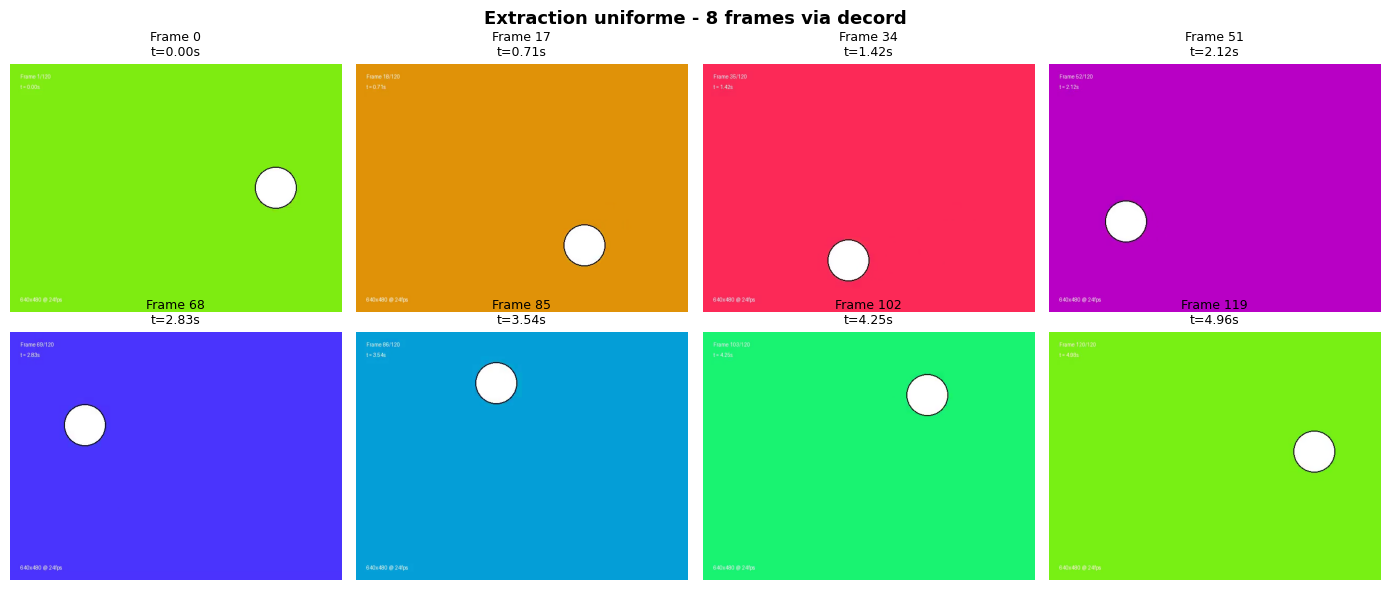


2. Benchmark : frame par frame vs batch
  Sequential (8 frames) : 34.8ms
  Batch (8 frames) : 19.9ms
  Acceleration batch : x1.7


In [8]:
# Extraction de frames avec decord
if enable_decord_demo and dependencies.get('decord', False) and test_video_path.exists():
    import decord
    decord.bridge.set_bridge('native')
    
    print("\n--- EXTRACTION DE FRAMES AVEC DECORD ---")
    print("=" * 45)
    
    # Creer un VideoReader
    vr = decord.VideoReader(str(test_video_path))
    total_frames = len(vr)
    avg_fps = vr.get_avg_fps()
    
    print(f"VideoReader initialise")
    print(f"  Frames totales : {total_frames}")
    print(f"  FPS moyen : {avg_fps:.2f}")
    print(f"  Duree estimee : {total_frames / avg_fps:.2f}s")
    
    # Extraction de frames specifiques
    print("\n1. Extraction uniforme (8 frames)")
    n_extract = 8
    indices = np.linspace(0, total_frames - 1, n_extract, dtype=int).tolist()
    print(f"  Indices : {indices}")
    
    start_time = time.time()
    batch = vr.get_batch(indices)
    frames_np = batch.asnumpy()
    extract_time = time.time() - start_time
    
    print(f"  Extraction en {extract_time * 1000:.1f}ms")
    print(f"  Shape batch : {frames_np.shape}")
    
    # Conversion en images PIL pour affichage
    frames_pil = [Image.fromarray(frames_np[i]) for i in range(len(indices))]
    
    # Affichage en grille
    cols = 4
    rows = (n_extract + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows))
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, ax in enumerate(axes_flat):
        if i < n_extract:
            ax.imshow(frames_np[i])
            t_sec = indices[i] / avg_fps
            ax.set_title(f"Frame {indices[i]}\nt={t_sec:.2f}s", fontsize=9)
        ax.axis('off')
    
    plt.suptitle(f"Extraction uniforme - {n_extract} frames via decord",
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Benchmark : extraction frame par frame vs batch
    print("\n2. Benchmark : frame par frame vs batch")
    
    # Frame par frame
    start_time = time.time()
    for idx in indices:
        _ = vr[idx]
    time_sequential = time.time() - start_time
    
    # Batch
    start_time = time.time()
    _ = vr.get_batch(indices)
    time_batch = time.time() - start_time
    
    print(f"  Sequential ({n_extract} frames) : {time_sequential * 1000:.1f}ms")
    print(f"  Batch ({n_extract} frames) : {time_batch * 1000:.1f}ms")
    if time_sequential > 0:
        speedup = time_sequential / max(time_batch, 0.001)
        print(f"  Acceleration batch : x{speedup:.1f}")
    
else:
    if not dependencies.get('decord', False):
        print("decord non disponible - section sautee")
    else:
        print("Video de test non trouvee ou decord desactive")

In [9]:
# Mode interactif - Exploration personnalisee
if notebook_mode == "interactive" and not skip_widgets:
    print("\n--- MODE INTERACTIF ---")
    print("=" * 40)
    print("Entrez un chemin vers un fichier video pour l'analyser.")
    print("(Laissez vide pour passer a la suite)")
    
    try:
        user_video = input("\nChemin video (ou vide) : ").strip()
        
        if user_video and Path(user_video).exists():
            print(f"\nAnalyse de : {user_video}")
            
            if dependencies.get('ffmpeg-python', False):
                probe = ffmpeg.probe(user_video)
                fmt = probe['format']
                vs = next((s for s in probe['streams'] if s['codec_type'] == 'video'), None)
                if vs:
                    fps_parts = vs.get('r_frame_rate', '0/1').split('/')
                    fps = int(fps_parts[0]) / int(fps_parts[1]) if len(fps_parts) == 2 else 0
                    print(f"  Resolution : {vs.get('width')}x{vs.get('height')}")
                    print(f"  Codec : {vs.get('codec_name')}")
                    print(f"  FPS : {fps:.2f}")
                    print(f"  Duree : {float(fmt.get('duration', 0)):.2f}s")
            
            if dependencies.get('decord', False):
                vr_user = decord.VideoReader(user_video)
                user_indices = np.linspace(0, len(vr_user) - 1, 4, dtype=int).tolist()
                user_batch = vr_user.get_batch(user_indices).asnumpy()
                
                fig, axes = plt.subplots(1, 4, figsize=(14, 3))
                for i, ax in enumerate(axes):
                    ax.imshow(user_batch[i])
                    ax.set_title(f"Frame {user_indices[i]}", fontsize=9)
                    ax.axis('off')
                plt.suptitle(f"Apercu : {Path(user_video).name}", fontweight='bold')
                plt.tight_layout()
                plt.show()
        elif user_video:
            print(f"Fichier non trouve : {user_video}")
        else:
            print("Mode interactif ignore")
    
    except (KeyboardInterrupt, EOFError) as e:
        print(f"\nMode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\nMode interactif non disponible (execution automatisee)")
        else:
            print(f"\nErreur inattendue : {error_type} - {str(e)[:100]}")
            print("Passage a la suite du notebook")
else:
    print("\nMode batch - Interface interactive desactivee")


Mode batch - Interface interactive desactivee


## Bonnes pratiques et conseils d'optimisation

| Bibliotheque | Cas d'usage ideal | Avantage principal | Inconvenient |
|-------------|-------------------|-------------------|-------------|
| **moviepy** | Montage, effets, composition | API haut niveau, riche en fonctionnalites | Lent pour gros fichiers, consomme de la RAM |
| **ffmpeg-python** | Inspection metadonnees, conversion | Rapide, wrapper leger | Syntaxe pipeline peu intuitive |
| **decord** | Extraction de frames pour ML | Tres rapide, batch GPU possible | Pas de fonctions de montage |
| **imageio** | Lecture/ecriture simple | Simple, bon pour prototypes | Moins performant que decord pour gros volumes |

**Recommandations** :
- Utilisez **decord** pour extraire des frames destinees a des modeles de vision (GPT-5, Qwen-VL)
- Utilisez **ffmpeg-python** pour inspecter les metadonnees sans decoder la video
- Utilisez **moviepy** pour le montage et la composition
- Utilisez **imageio** pour des scripts simples de conversion frames <-> video

In [10]:
# Statistiques de session et prochaines etapes
print("\n--- STATISTIQUES DE SESSION ---")
print("=" * 40)

print(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Mode : {notebook_mode}")
print(f"Video de test : {sample_width}x{sample_height} @ {sample_fps}fps, {sample_duration}s")

# Lister les fichiers generes
if save_results and OUTPUT_DIR.exists():
    generated_files = list(OUTPUT_DIR.glob('*'))
    print(f"\nFichiers generes ({len(generated_files)}) :")
    for f in sorted(generated_files):
        size_kb = f.stat().st_size / 1024
        print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nDependances utilisees :")
for dep, available in dependencies.items():
    status = "utilisee" if available else "non disponible"
    print(f"  {dep} : {status}")

print(f"\n--- PROCHAINES ETAPES ---")
print(f"1. Notebook 01-2 : Comprehension video avec GPT-5 (extraction frames + analyse API)")
print(f"2. Notebook 01-3 : Analyse video locale avec Qwen2.5-VL (GPU requis)")
print(f"3. Notebook 01-4 : Amelioration video avec Real-ESRGAN (upscaling)")
print(f"4. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)")

print(f"\nNotebook 01-1 Video Operations termine - {datetime.now().strftime('%H:%M:%S')}")


--- STATISTIQUES DE SESSION ---
Date : 2026-02-26 07:49:21
Mode : batch
Video de test : 640x480 @ 24fps, 5s

Fichiers generes (3) :
  concatenated.mp4 (55.0 KB)
  test_video.mp4 (64.1 KB)
  trimmed.mp4 (32.9 KB)

Dependances utilisees :
  moviepy : utilisee
  ffmpeg-python : utilisee
  decord : utilisee
  imageio : utilisee

--- PROCHAINES ETAPES ---
1. Notebook 01-2 : Comprehension video avec GPT-5 (extraction frames + analyse API)
2. Notebook 01-3 : Analyse video locale avec Qwen2.5-VL (GPU requis)
3. Notebook 01-4 : Amelioration video avec Real-ESRGAN (upscaling)
4. Notebook 01-5 : Introduction a AnimateDiff (generation text-to-video)

Notebook 01-1 Video Operations termine - 07:49:21


---

# CHALLENGE BONUS - Générateur de Slideshow Vidéo

**Points : 0.5 pts**

## Objectif

Créer une vidéo **slideshow** à partir de frames générées programmatiquement.

## Ce que vous avez appris

La Section 1 montre:
- Génération de frames avec PIL (`Image.new`, `ImageDraw`)
- Assemblage avec imageio (`get_writer`, `append_data`)

## Criteres de succes

- [ ] Générer **5 frames** affichant un message différent chacune:
  - Frame 1: "Bienvenue"
  - Frame 2: "Voici le sujet"
  - Frame 3: "Point important"
  - Frame 4: "Conclusion"
  - Frame 5: "Merci"
- [ ] Chaque frame doit avoir:
  - Une couleur de fond différente (gradient ou palette cohérente)
  - Le texte centré
- [ ] Assembler en vidéo **5 secondes @ 1 FPS**
- [ ] Sauvegarder dans `OUTPUT_DIR`

## Contraintes techniques

- Résolution: 640x480
- Utiliser PIL pour les frames, imageio pour l'assemblage
- FPS = 1 signifie chaque frame dure 1 seconde

---

**Soumission** : PR avec titre "Challenge #7 - [Votre Nom]", aperçu des frames et vidéo générée